## Goal: evaluate the relevance of different factors in causing asthma in NYC.

Method:
work on the ZIP code level.

1. Identify the 5 facilities that reported the highest incidence of asthma cases and find which ZIP code they fall in.

2. Develop a Metric for each of the fllowing: access to green space, murder rate, environmental health, and proximity to highways for each ZIP code (no panic, suggestions on how to proceed are in the hints file). You must choose AT LEAST 2 variables among these 4. We encourage you to work with three. Choosing 4 or more, and coming up with additional ones, is considered extra credit.

3. Show a table containing the value of each variable of interest for the 5 ZIP codes corresponding to the highest cases of Asthma.

4. Display each of your metrics as a choropleth (a heatmap version of a geographical map where each zip code is a different color based on the value of the metric you are mapping).

5. Fit a model (try a multivariable linear model for example or any other model which you think may be reasonable, keeping in mind you will need to use the model in the last task) to the incidence of asthma cases per NYC ZIP code (this is your dependent variable) as a function of variables mentioned above, based on the ZIP codes of the top 5 facilities reporing asthma.

6. Cluster the ZIP codes using the model you generated in step 4 as a distance metric (suggestions if needed are in the hints file).

7. Discuss. What did you find? What is the spatial coherence of the different factors considered, which variables seem to be more important in triggering asthma cases, what are the weaknesses of the model, how does the clustering look.

In [774]:
__author__ = "me"
__date__ = "2015_10_13"

%pylab inline
import pandas as pd
import numpy as np
import geopandas as gpd
import mplleaflet

from pandas.tools.plotting import scatter_matrix
import pylab as plt
import os
import pysal

import statsmodels.formula.api as smf

import sklearn.cluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import cophenet
from scipy.cluster.hierarchy import fcluster
from scipy.spatial.distance import pdist

from sklearn.metrics import r2_score
from sklearn.decomposition import PCA


import requests
from cStringIO import StringIO

try:
    s= requests.get("https://raw.githubusercontent.com/Casyfill/\
                    CUSP_templates/master/Py/fbMatplotlibrc.json").json()
    plt.rcParams.update(s)
except: 
    pass

try:
    
    from palettable.cubehelix import  red_16_r
    from palettable.wesanderson import  FantasticFox2_5
    mycolormap = red_16_r.mpl_colormap
    mycolormap2 = FantasticFox2_5.mpl_colormap
    print 'done! nice colormaps loaded'
except:
    mycolormap = 'Blues'
    mycolormap2 = 'winter'
    print 'nope( loaded standart colormaps'
    
PWD = os.getenv('PWD')

Populating the interactive namespace from numpy and matplotlib
done! nice colormaps loaded


`%matplotlib` prevents importing * from pylab and numpy


## SQL Helper

In [2]:
def myQueryCartoDB(query = 'SELECT * FROM nyc_discharge_2013 LIMIT 3', user = 'htv210', rFormat = "CSV"):
    
    source = 'http://{user}.cartodb.com/api/v2/sql'.format(user = user)
    
    params = { 'q': query, 
                'format': rFormat}
    
    r = requests.get(source, params = params)
    r.raise_for_status()
    
    
    if rFormat == 'CSV':
        return pd.read_csv(StringIO(r.content))
    elif rFormat =='GeoJSON':
        return gpd.GeoDataFrame.from_features(r.json()['features'])
    else:
        print 'unknown format'
        
    
    

## QUERIES

In [538]:
dischargeQuery = '''

SELECT facility_id, COUNT(*) AS count 
FROM nyc_discharge_2013  
WHERE lower(ccs_diagnosis_description) LIKE '%asthma%' 
GROUP BY facility_id
ORDER BY count DESC
LIMIT 5;
'''

testQuery = 'SELECT * FROM nyc_discharge_2013  LIMIT 20'

# TASK I

In [585]:
myQueryCartoDB(testQuery).columns

Index([u'cartodb_id', u'the_geom', u'the_geom_webmercator', u'hospital_county',
       u'operating_certificate_number', u'facility_id', u'age_group',
       u'zip_code___3_digits', u'gender', u'race', u'ethnicity',
       u'length_of_stay', u'admit_day_of_week', u'type_of_admission',
       u'patient_disposition', u'discharge_year', u'discharge_day_of_week',
       u'ccs_diagnosis_code', u'ccs_diagnosis_description'],
      dtype='object')

In [586]:
facilities = myQueryCartoDB(query = dischargeQuery)

In [587]:
facilities

,facility_id,count
0,1172,1878
1,1169,1786
2,1301,1057
3,1165,920
4,1178,890


In [588]:
topID = str(tuple(facilities.facility_id.tolist()))

facilityQuery = '''SELECT * FROM nyc_facilities WHERE facility_id in %s''' % topID

print facilityQuery

SELECT * FROM nyc_facilities WHERE facility_id in (1172, 1169, 1301, 1165, 1178)


In [589]:
allFacilitiesRaw =  myQueryCartoDB(query = facilityQuery, rFormat = 'GeoJSON')

In [590]:
allFacilities = allFacilitiesRaw.merge(facilities, how='left', on = 'facility_id')
                                .rename(columns = {'facility_zip_code':'zipcode'})
    
output = allFacilities[['geometry','facility_id','facility_name', 'count', 'zipcode']]
output

,geometry,facility_id,facility_name,count,zipcode
0,POINT (-73.84674099999999 40.857388),1165,Jacobi Medical Center,920,10461
1,POINT (-73.880562 40.879951),1169,Montefiore Medical Center - Henry & Lucy Moses...,1786,10467
2,POINT (-73.92421 40.817661),1172,Lincoln Medical & Mental Health Center,1878,10451
3,POINT (-73.911545 40.843609),1178,Bronx-Lebanon Hospital Center - Concourse Divi...,890,10457
4,POINT (-73.94409899999999 40.655823),1301,Kings County Hospital Center,1057,11203


In [591]:
zipquery = '''SELECT * FROM nyc_zipcode_highway'''
allZips =  myQueryCartoDB(query=zipquery, rFormat='GeoJSON')
allZips.crs = {'init': 'epsg:4326', 'no_defs': True}
allZips.to_crs(epsg=2236, inplace=1)


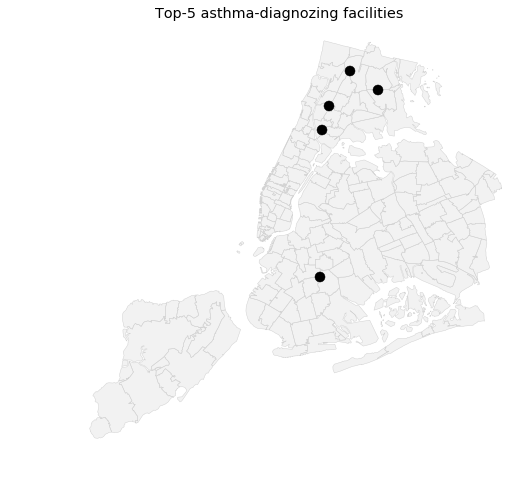

In [592]:
#  OPTIONAL, works good with geopandas dev version (main release does not support markersize)

try:
    allFacilities.crs = {'init': 'epsg:4326', 'no_defs': True}
    allFacilities.to_crs(allZips.crs, inplace=1)

    fig,ax = plt.subplots(figsize = (8,8))

    ## very slow to plot on sloppy maps
    allZips.plot(ax = ax, alpha=0.1, color='grey', linewidth = .5, edgecolor = 'lightgrey') 

    allFacilities.plot(ax = ax, markersize = 10, color = 'k')
    ax.set_axis_off()
    ax.set_title('Top-5 asthma-diagnozing facilities')
    
except Exception, e:
    print str(e)
    pass 

In [593]:
fig,ax = plt.subplots(figsize=(6,6))



allFacilities.plot(ax=ax, markersize=10, color='k')
ax.set_axis_off()

mplleaflet.display(fig = fig, crs=allFacilities.crs, tiles='cartodb_positron')

# II. Hightway lenghts

In [643]:
zipcodes = str(tuple(allFacilities.zipcode.tolist()))

hightwayQuery = '''SELECT * FROM nyc_zipcode_highway WHERE zipcode in %s''' % zipcodes
hightwayAllQuery = '''SELECT * FROM nyc_zipcode_highway'''

In [644]:
ourZips1 =  myQueryCartoDB(query=hightwayQuery, rFormat='GeoJSON')


In [652]:
ourZips = ourZips1.merge(output[['zipcode','count']], how='left', on='zipcode')
                  .rename(columns={'count':'cases'})
    
ourZips.crs = {'init': 'epsg:4326', 'no_defs': True}
ourZips.to_crs(allZips.crs, inplace=1)

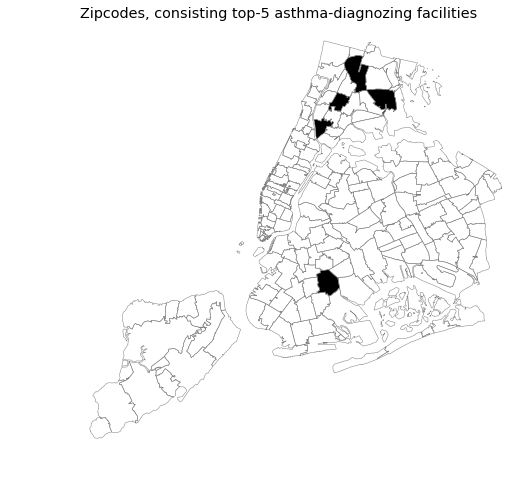

In [653]:
fig,ax = plt.subplots(figsize=(8,8))

ourZips.plot(ax=ax, alpha=1, color='k', linewidth=0)
allZips.plot(ax=ax, alpha=0, linewidth=.5, edgecolor='grey')

ax.set_axis_off()
ax.set_title('Zipcodes, consisting top-5 asthma-diagnozing facilities');


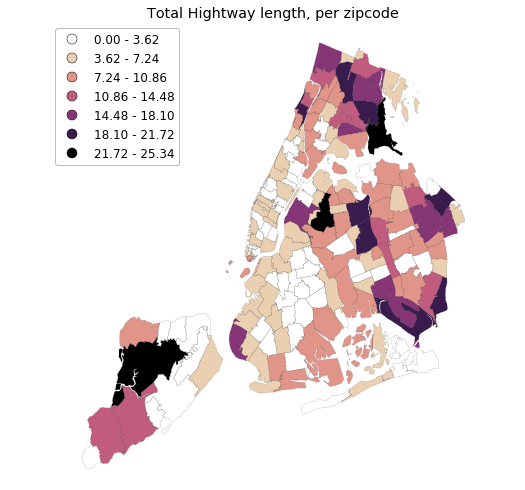

In [142]:
fig,ax = plt.subplots(figsize=(8,8))

allZips.plot(column='highway_length', linewidth=0.1, 
             alpha=1, cmap=mycolormap, ax=ax, 
             legend=True, scheme='equal_interval', k=7)

ax.set_title('Total Hightway length, per zipcode')
ax.set_axis_off()

## 311 Calls

In [776]:
allCalls = pd.read_csv(PWD + '/data/311calls.csv')

In [777]:
## faster than processing into datetime :-P
calls = allCalls[(allCalls['Created Date']\
                  .str.contains('2013'))& (pd.notnull(allCalls['Incident Zip']))]

In [164]:
totalZip = calls['Incident Zip'].value_counts()
                                .reset_index()
                                .rename(columns={'Incident Zip':'totalCalls'})
totalZip.head()

,index,totalCalls
0,11226,15460
1,10467,12729
2,10458,11342
3,11207,11224
4,10452,10784


here is my subjective choice of relevant complains: it is based on this list
http://www.mayoclinic.org/diseases-conditions/asthma/basics/causes/con-20026992
Plus, Alex had a great presentation on how water system quality works as a great predictor of asthma, 
so I included everything, related to it as well.

In [ ]:
conditions = ['Industrial Waste', 'Asbestos', 'Boilers',
              'Indoor Sewage','Water Quality','PAINT/PLASTER',
              'Unsanitary Pigeon Condition','Mold','Collection Truck Noise',
              'Poison Ivy','Harboring Bees/Wasps','Drinking Water',
              'Unsanitary Animal Facility','Radioactive Material','Hazmat Storage/Use',
              'HEATING','GENERAL CONSTRUCTION','Street Light Condition',
              'PLUMBING','PAINT - PLASTER','Street Condition',
              'Blocked Driveway','NONCONST','Water System',
              'Broken Muni Meter','Dirty Conditions','Sewer',
              'Sanitation Condition','General Construction/Plumbing','Rodent',
              'Root/Sewer/Sidewalk Condition','Air Quality','Construction',
              'APPLIANCE','UNSANITARY CONDITION']

with a bit of experiment and analysis, I narrowed down the list, which dramatically improved the result
of course, this may lead to overfitting, speaking generally - or may outline general factors of asthma

In [322]:
conditions2 = ['UNSANITARY CONDITION','Mold', 'Dirty Conditions', 'Sewer',
                   'Indoor Air Quality','Indoor Sewage','Air Quality',
                   'HEATING','Industrial Waste','Asbestos',
                   'Lead','Unsanitary Animal Facility']

In [323]:

asthmaCalls2 = calls[calls['Complaint Type'].isin(conditions2)]

In [324]:
asthmaZip2 = asthmaCalls2['Incident Zip'].value_counts()
                                         .reset_index()
                                         .rename(columns={'Incident Zip':'asthmaCalls'})
asthmaZip2.head()

,index,asthmaCalls
0,10467,3686
1,11226,3522
2,10468,3397
3,10040,3365
4,10458,3237


In [326]:
asthmaDF2 = totalZip.merge(asthmaZip2, how='left', on='index')
                    .fillna(0).rename(columns={'index':'zipcode'})
    
    
asthmaDF2['asthmaNorm'] = asthmaDF2.asthmaCalls/ asthmaDF2.totalCalls
asthmaDF2.head()

,zipcode,totalCalls,asthmaCalls,asthmaNorm
0,11226,15460,3522,0.227814
1,10467,12729,3686,0.289575
2,10458,11342,3237,0.285399
3,11207,11224,1725,0.153689
4,10452,10784,3012,0.279303


In [327]:
ourZips2 = ourZips.merge(asthmaDF2[['zipcode','asthmaNorm']], how='left', on='zipcode')
                  .rename(columns={'asthmaNorm':'calls311'})
    
ourZips2.head()

,cartodb_id,geometry,highway_length,zipcode,cases,calls311
0,106,"(POLYGON ((-73.863293 40.89529, -73.862875 40....",19.172015,10467,1786,0.362319
1,111,"(POLYGON ((-73.931681 40.807955, -73.931704 40...",7.914185,10451,1878,0.334665
2,123,"(POLYGON ((-73.897516 40.856183, -73.896533000...",5.017199,10457,890,0.278846
3,125,"(POLYGON ((-73.82612399999999 40.834214, -73.8...",18.102258,10461,920,0.216197
4,195,"(POLYGON ((-73.942503 40.638965, -73.943986 40...",2.212840,11203,1057,0.243334


In [490]:

allZips2 = allZips.merge(asthmaDF2[['zipcode','asthmaNorm']], how='left', on='zipcode')
                  .rename(columns={'asthmaNorm':'calls311'})
    
allZips2.fillna(0,inplace=1)

In [491]:
allZips2.crs = {'init': 'epsg:4326', 'no_defs': True}
allZips2.to_crs(zips.crs, inplace=1)

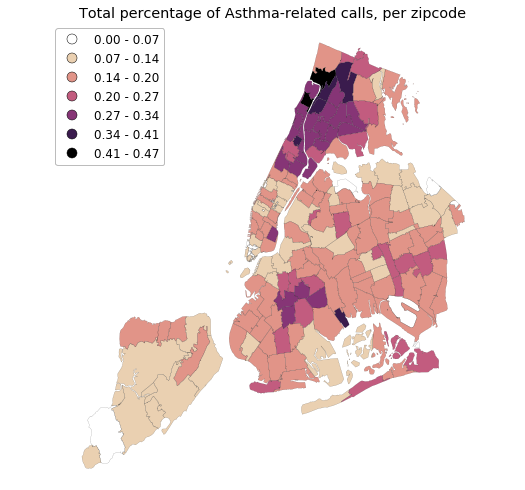

In [492]:
fig,ax = plt.subplots(figsize=(8,8))

allZips2.plot(column='calls311', linewidth=0.1, 
             alpha=1, cmap=mycolormap, ax=ax, 
             legend=True, scheme='equal_interval', k=7)

ax.set_title('Total percentage of Asthma-related calls, per zipcode')
ax.set_axis_off()

# TASK 6

In [406]:
data = ourZips2[['cases','calls311','highway_length']]
data = (data - data.mean())/data.std()

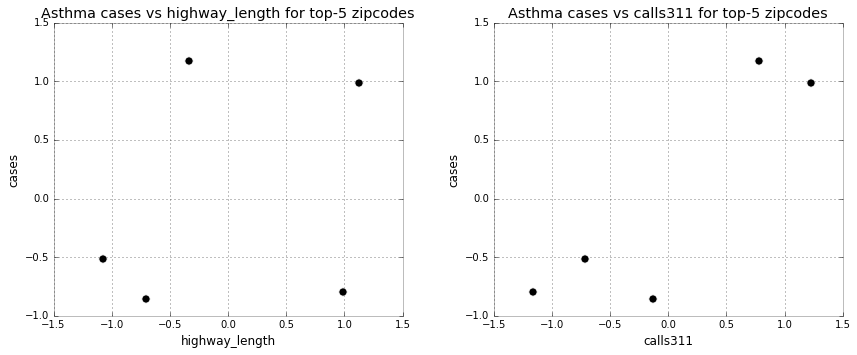

In [369]:
fig, axes = plt.subplots(1,2, figsize=(12,5))



for i, name in enumerate(('highway_length', 'calls311')):

    data.plot(kind='scatter', ax=axes[i], s=70, color='k', x=name, y='cases')
    axes[i].set_title('Asthma cases vs %s for top-5 zipcodes' % name)

plt.tight_layout()

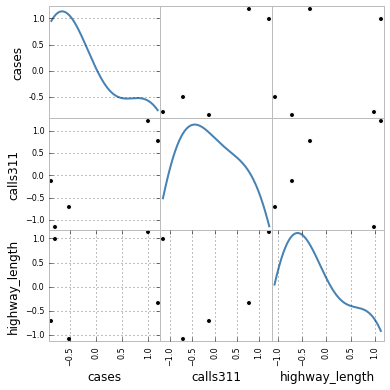

In [370]:
scatter_matrix(data, alpha=1, c='k', figsize=(6, 6),s=100, diagonal='kde');

In [371]:
def getPlotLinear(df, ind_col='X', dep_col='Y', summary=True):
	'''plots linear model through 1-var regression
	requres statsmodels.formula.api as smf'''

	dt = df[[ind_col, dep_col]].rename(columns={ind_col:'X',dep_col:'Y' })
	
	lm = smf.ols('Y ~ X', dt, missing = 'drop').fit()
	if summary:
		print lm.summary()

	dx=  pd.DataFrame({'X': np.linspace(dt.X.min(), dt.X.max(), 100)})

	dt.plot(kind='scatter', 
              figsize=(8,8), 
              x='X', 
              y='Y', 
              color='k',
              s=60,
              title='Number of residential units vs number of rides, Zipcodes');

	plt.xlabel(ind_col);
	plt.ylabel(dep_col);
	plt.plot(dx, lm.predict(dx),'r')


In [372]:
def getLM(df, ind_cols=['X1'], dep_col='Y', summary=True):
    '''generate linear model'''
    
    formula = dep_col + ' ~ ' + ' + '.join(ind_cols)
    print formula

    lm = smf.ols(formula, df, missing = 'drop').fit()
    if summary:
        print lm.summary()
    
    return lm


### Two-variable linear model

In [373]:
results = getLM(data, ind_cols=('highway_length', 'calls311'), dep_col='cases')

cases ~ highway_length + calls311
                            OLS Regression Results                            
Dep. Variable:                  cases   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     3.811
Date:                Mon, 21 Dec 2015   Prob (F-statistic):              0.208
Time:                        20:04:15   Log-Likelihood:                -2.6098
No. Observations:                   5   AIC:                             11.22
Df Residuals:                       2   BIC:                             10.05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept 

### Linear mode

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     10.91
Date:                Mon, 21 Dec 2015   Prob (F-statistic):             0.0456
Time:                        20:04:15   Log-Likelihood:                -2.7017
No. Observations:                   5   AIC:                             9.403
Df Residuals:                       3   BIC:                             8.622
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -8.266e-17      0.240  -3.45e-16      1.0

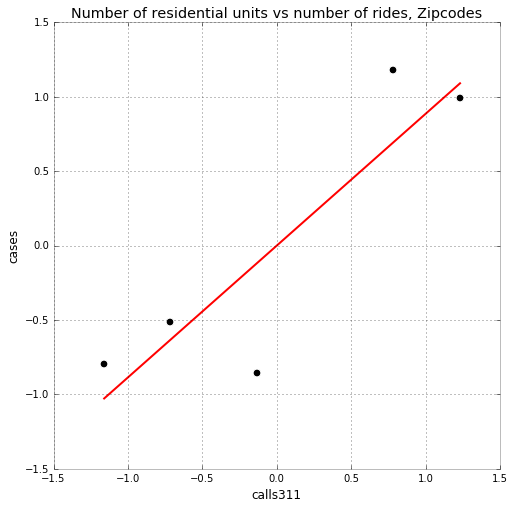

In [374]:
getPlotLinear(data, ind_col='calls311', dep_col='cases', summary=True)

### Speculation over the model

The result of the multivariable model is quite mediocre: .584 adjusted Rsquare on 5 points sounds quite patetic. Indeed, both parameters have p-values way highter than .05 limit.

On the other side, it looks like 311 parameter by itself can explain the rate of asthma much better: in the linear model adjusted R-square is .712, and the p-value is low enough.

There might be many reasons why result is that mediocre: for example, people might not choose just the closest hospital. on the other hand, none of the independent variables is not the best: we might add multiple new variables to the model, starting with sociodemographics. In their work [1] Corbun, Osleeb and Porter outline those factors ass good predictors: low-income, being a minority, substandard housing, and others. [1]



[1] Corburn, J., Osleeb, J., & Porter, M. (2006). Urban asthma and the neighbourhood environment in New York City. Health & place, 12(2), 167-179.

On my side, I'd offer to to add:
    1. average income (or income of the first quantile) in the zipcode  
    2. age of the building
    3. mungle 311 data more, for example aggregating data by the Agency and performing a PCA analysys

# TASK 7

In [493]:
data2 = allZips2[['zipcode','calls311','highway_length']].set_index('zipcode')
data2 = (data2 - data2.mean())/data2.std()

In [494]:
weights = results.params.to_dict()
weights

{'Intercept': -8.2662171678458461e-17,
 'calls311': 0.86657140112784348,
 'highway_length': 0.090286407373813549}

In [495]:
for key in ( k for k in weights if k in data2.columns.tolist()):
    print key, weights[key]
    data2[key] = data2[key]*weights[key]

calls311 0.866571401128
highway_length 0.0902864073738


In [496]:
data2.head()

,calls311,highway_length
zipcode,,
10314,-0.600396,0.282102
10112,-1.464306,-0.096905
10048,-1.464306,-0.073548
10171,-1.464306,-0.096905
10172,-1.464306,-0.096905


In [497]:
def hierarchical(df, truncate = False, ps=3):
    Z = linkage(df, 'ward')
    
    c, coph_dists = cophenet(Z, pdist(df))
    print c
    
    labels = fcluster(Z, ps, criterion='maxclust')
    
#     All clusters
    if truncate:
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index')
        plt.ylabel('distance')
        
        dendrogram(
            Z,
            truncate_mode='lastp',  # show only the last p merged clusters
            p=ps,  # show only the last p merged clusters
            show_leaf_counts=False,  # otherwise numbers in brackets are counts
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,  # to get a distribution impression in truncated branches
        )
        plt.show()
        
    else:
        plt.figure(figsize=(25, 10))
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('sample index')
        plt.ylabel('distance')
        dendrogram( Z,
        leaf_rotation=0.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
        )
        plt.show()
    
    return labels

0.950155973443


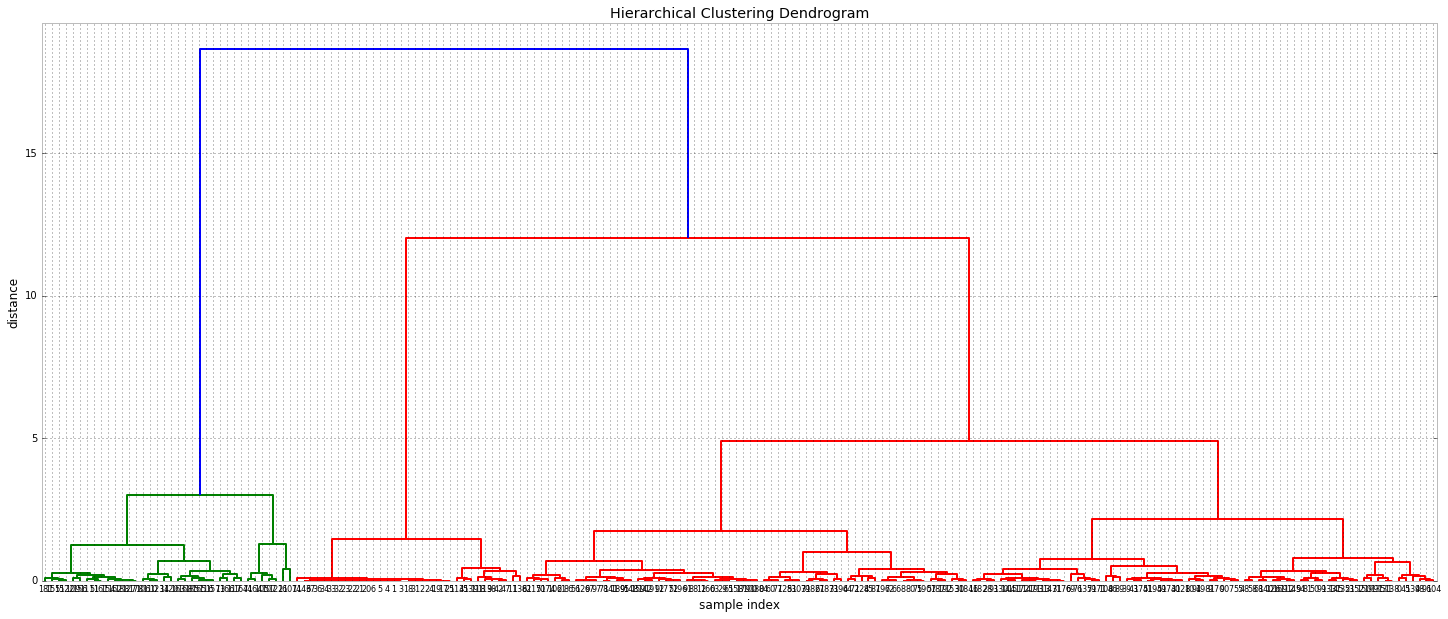

In [524]:
data2['labels']  = hierarchical(data2, truncate= False, ps=3)


In [520]:
allZips3 = allZips2.merge(data2.reset_index()[['zipcode','labels']], how='left', on='zipcode')

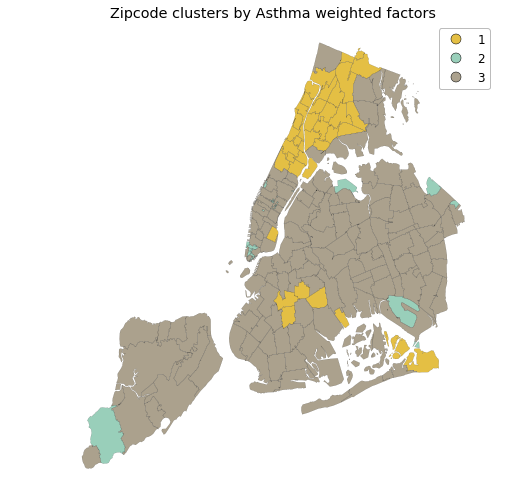

In [522]:
fig,ax = plt.subplots(figsize=(8,8))


allZips3.plot(column='labels', linewidth=0.1, 
             alpha=1, cmap = mycolormap2, edgecolor = 'k', 
             ax=ax, legend = True, categorical = True)

ax.set_title('Zipcode clusters by Asthma weighted factors')
ax.set_axis_off()

This project has its goal to evaluate different metrics as predictor of number of asthma cases for NYC city, using data for 5 most-diagnosing.

As such, we used two metrics: total leght of highways and normalized number of asthma-related 311 calls. The model we fitted (linear multivariate least-square model) performs with the adjusted R-squared value of 0.584. At the same time, 311 calls by themself performs better, having adjusted R-square of 0.712, and the impact of 311 calls is significantly highter.

Despite the relatively hight level of R-square, model seems to be quite inaccurate, as p-values do not pass the limit of .05 alpha - we cannot reject the hypotesis that any correlation is just matter of chance. The reason for low quality is two-fold:
on one side, both independent variables seems to have  some methodological problems: Highways seems to have low general impact (in comparison to others), while 311 complain types are collected with the questionable method of manual feature selection: I was able to improve R-square significantly by sifting the list of complain types.


On the other side, the dependent variable metric is questionable as well: first, we use values for only top-5 hospitals as our metrics. Second, we do not normalize number of cases per total cases (or, maybe, total emergency cases) in the hospital. Third - it might be a better idea to aggregate numbers per zipcode, rather than assigning hospital numbers to the zipcode, as there is a chance that there will be a zipcode with two hospitals

Of course, the whole concept of zipcode-based aggregation is also not entirely correct, as there might be a hospital "in the corner of zipcode", meaning that it will be closest for several other zipcodes, while not the closest for some parts of it's own zipcode.

On the second phase of the project,  we made an attempt to "interpolate" our model by implementing it's coefficients as weights for the clustering algorithm (in my case I chose "ward" dendogram with 3 clusters). As 311 calls have way larger impact on the result, we can interpret the result of clustering by comparing it with the 311 choropleth: It basically outlines zones of "hight risk", average risk and low risk of asthma. As it use 311 data the most, two spatial representations has a strong correlation: we can see how 7 areas are named as low-risk areas, through 3 of them are: laGuardia Airport, JFK Airport and the closed landfill on the Staten Island. 3 of four other zipcodes are very small. As we know that most of the impact is on the 311 side, we might interpret this as a very low level of "asthma" calls as a fraction of total number of calls - mostly just representing the whole different structuore of the zipcode: as we selected all construction issues, old structures and bad environment issues as "asthma calls", this may represent the lack of buildings in general, for example; In other words, we cant rely on this assumption: Yet I am very curious if this prediction really works for [Dooglaston](http://www.nytimes.com/2004/02/08/realestate/if-you-re-thinking-living-douglaston-queens-timeless-city-area-with-country-feel.html?_r=0).

## EXTRA CREDIT

### I. Lets first evaluate our results using same methodics

In [526]:
dischargeAllQuery = '''

SELECT facility_id, COUNT(*) AS count 
FROM nyc_discharge_2013  
WHERE lower(ccs_diagnosis_description) LIKE '%asthma%' 
GROUP BY facility_id
ORDER BY count DESC;
'''

In [670]:
all_Asthma =  myQueryCartoDB(query=dischargeAllQuery)

In [671]:
allAsthmaFacilityQuery = '''SELECT * FROM nyc_facilities'''

In [672]:
allHospitals =  myQueryCartoDB(query=allFacilityQuery, rFormat='GeoJSON')

In [673]:
allHospitalsAsthma = allHospitals.merge(all_Asthma, how='left', on='facility_id')
allHospitalsAsthma.rename(columns = {'facility_zip_code':'zipcode'}, inplace=1)

allCases = allHospitalsAsthma.groupby('zipcode')
                             .agg({'count':'sum'}).reset_index()
                             .rename(columns={'count':'cases'})

In [674]:
allZipsAsthma = allZips.merge(allCases, how='left', on='zipcode') 
allZipsAsthma = allZipsAsthma[pd.notnull(allZipsAsthma['cases'])]

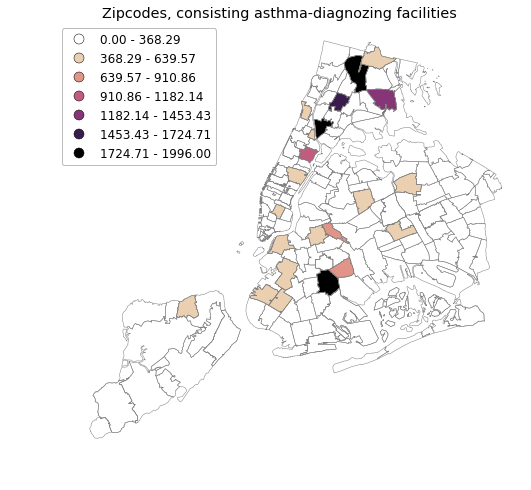

In [675]:
fig,ax = plt.subplots(figsize=(8,8))


allZips.plot(ax=ax, alpha=0, linewidth=.5, edgecolor='grey')

allZipsAsthma.plot(column='cases', 
                   linewidth=.5, ax=ax,
                   cmap=mycolormap,
                   edgecolor='grey',
                   legend=True, alpha=1, 
                   scheme='equal_interval', k=7)


ax.set_axis_off()
ax.set_title('Zipcodes, consisting asthma-diagnozing facilities');

#### Now we shall add independent variables to this dataset as well

In [676]:
allZipsAsthma2 = allZipsAsthma.merge(asthmaDF2[['zipcode','asthmaNorm']], how='left', on='zipcode')
                              .rename(columns={'asthmaNorm':'calls311'})

In [677]:
allZipsAsthma2.head()

,cartodb_id,geometry,highway_length,zipcode,cases,calls311
0,17,"(POLYGON ((2569968.700994517 6008595.69840219,...",0.000000,10310,404,0.153005
1,29,"(POLYGON ((2616223.525779105 6031121.21312683,...",1.416299,11206,486,0.158419
2,40,(POLYGON ((2601919.204618645 6058667.832884224...,2.108747,10019,289,0.136179
3,41,(POLYGON ((2609062.922141774 6059975.580142415...,4.232831,10021,562,0.129187
4,52,"(POLYGON ((2662767.567684821 6001397.280198, 2...",3.422208,11691,224,0.265500


In [678]:
data2 = allZipsAsthma2[['cases','calls311','highway_length']]
data2 = (data2 - data2.mean())/data2.std()

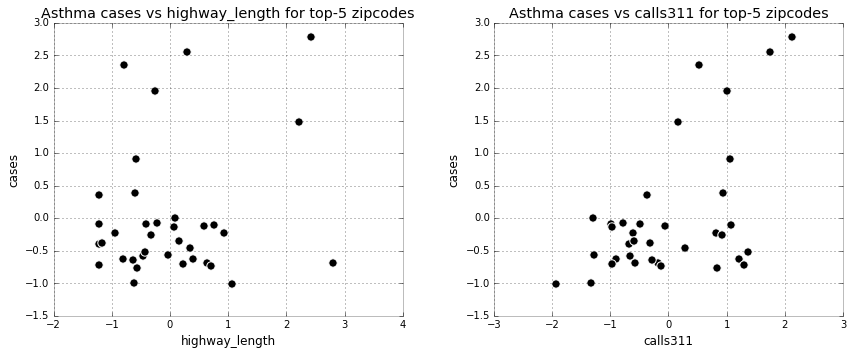

In [679]:
fig, axes = plt.subplots(1,2, figsize=(12,5))


for i, name in enumerate(('highway_length', 'calls311')):

    data2.plot(kind='scatter', ax=axes[i], s=70, color='k', x=name, y='cases')
    axes[i].set_title('Asthma cases vs %s for top-5 zipcodes' % name)

plt.tight_layout()

### Of course, the real quality of our model is very low

In [683]:
sklearn.metrics.r2_score(data2['cases'], results.predict(data2))

0.30817024827297879

It is as low as .308 when applied to the real dataset

There is also interesting occurded from the plot above: here, upper left corner of **cases vs. calls** chart should be the same as on the previous plot: yet it is not the case? While we didn't do anything with 311 cals, we aggregated the number of asthma cases for each zipcode this time: so the reason for that should be in the fact that some of top-5 hospitals have neighbour hospitals in the very same zipcodes, which might change the whole metric! Lets check this out!

In [685]:
data2top5 = data2.sort_values('cases', ascending=False).head(5)

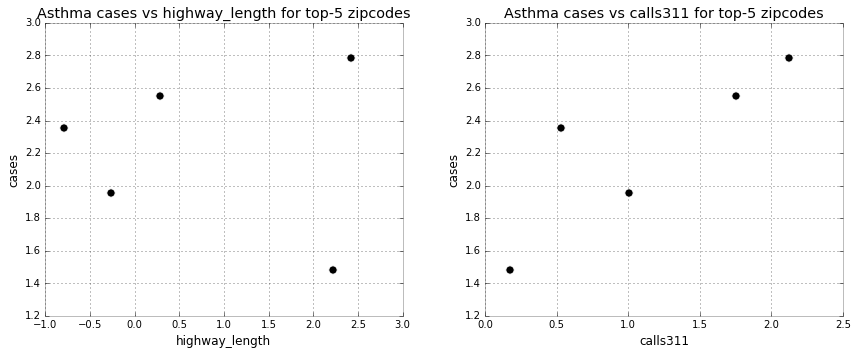

In [687]:
fig, axes = plt.subplots(1,2, figsize=(12,5))


for i, name in enumerate(('highway_length', 'calls311')):

    data2top5.plot(kind='scatter', ax=axes[i], s=70, color='k', x=name, y='cases')
    axes[i].set_title('Asthma cases vs %s for top-5 zipcodes' % name)

plt.tight_layout()

In [688]:
newModel = getLM(data2top5, ind_cols=('highway_length', 'calls311'), dep_col='cases')

cases ~ highway_length + calls311
                            OLS Regression Results                            
Dep. Variable:                  cases   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     3.743
Date:                Tue, 22 Dec 2015   Prob (F-statistic):              0.211
Time:                        13:12:49   Log-Likelihood:                0.65738
No. Observations:                   5   AIC:                             4.685
Df Residuals:                       2   BIC:                             3.514
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept 

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     7.738
Date:                Tue, 22 Dec 2015   Prob (F-statistic):             0.0689
Time:                        13:13:12   Log-Likelihood:              -0.046062
No. Observations:                   5   AIC:                             4.092
Df Residuals:                       3   BIC:                             3.311
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.6259      0.258      6.313      0.0

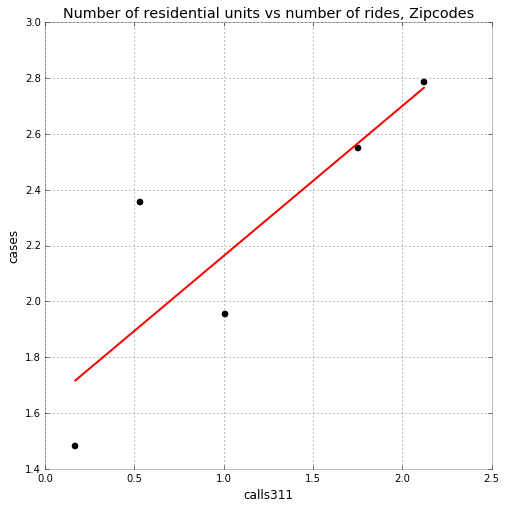

In [689]:
getPlotLinear(data2top5, ind_col='calls311', dep_col='cases', summary=True)

Indeed, data is changed! However, it didn't help us, morover, this data sounds to make even worser goodness-of-fit

## Extra credit II

As I don't believe in other two variables (parks and murder), I prefer to make another attempt to use 311 data: this time I want to avoid the manual feature selection and group features by the agency (or describtor), then perform Principal Components Analysis to reduce the dimencionality

In [714]:
AgencyZip = calls.rename(columns={'Incident Zip':'zipcode'})\
                 .groupby([ 'zipcode', 'Agency'])\
                 .size().unstack().fillna(0) #.reset_index()


AgencyZip.head(5) 

Agency,3-1-1,DCA,DEP,DFTA,DHS,DOB,DOE,DOF,DOHMH,DOITT,DOT,DPR,DSNY,EDC,FDNY,HPD,NYPD,TLC
zipcode,,,,,,,,,,,,,,,,,,
0,0,5,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,8
31,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
83,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,21,0
711,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1404,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [719]:
S = AgencyZip.sum(1)

for col in AgencyZip.columns.tolist():
    AgencyZip[col] = 100.0*AgencyZip[col]/S
    
AgencyZip.fillna(0, inplace=1)

In [720]:
AgencyZip.head(5)

Agency,3-1-1,DCA,DEP,DFTA,DHS,DOB,DOE,DOF,DOHMH,DOITT,DOT,DPR,DSNY,EDC,FDNY,HPD,NYPD,TLC
zipcode,,,,,,,,,,,,,,,,,,
0,0,15.151515,0,0,0,0,0,0,0,0,0,0.000000,60.606061,0,0,0,0.000000,24.242424
31,0,0.000000,0,0,0,0,0,0,100,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000
83,0,0.000000,0,0,0,0,0,0,0,0,0,8.695652,0.000000,0,0,0,91.304348,0.000000
711,0,0.000000,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0,0,0,0.000000,100.000000
1404,0,100.000000,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.000000


## now let's merge data

In [722]:
dataplus311 = allZipsAsthma2.merge(AgencyZip.reset_index(), on='zipcode', how='left')

In [739]:
data3 = dataplus311.drop(['cartodb_id','geometry'], 1).set_index('zipcode')

data3N = (data3 - data3.mean())/data3.std() ## to the same order of magnitude
data3.head()

,highway_length,cases,calls311,3-1-1,DCA,DEP,DFTA,DHS,DOB,DOE,...,DOHMH,DOITT,DOT,DPR,DSNY,EDC,FDNY,HPD,NYPD,TLC
zipcode,,,,,,,,,,,,,,,,,,,,,
10310,0.000000,404,0.153005,0,0.910747,16.302368,0.000000,0.000000,4.280510,0.091075,...,3.005464,0.000000,21.402550,6.921676,17.304189,0.091075,0.091075,16.393443,13.114754,0.091075
11206,1.416299,486,0.158419,0,1.357876,8.539529,0.000000,0.030175,5.009053,0.241400,...,3.741702,0.030175,16.385033,1.659626,9.746530,0.060350,0.030175,34.731442,17.712734,0.573325
10019,2.108747,289,0.136179,0,2.835774,14.241197,0.000000,0.000000,5.017139,0.218136,...,4.362730,0.093487,18.915550,0.872546,3.677158,0.031162,4.861328,17.887192,16.889997,9.629168
10021,4.232831,562,0.129187,0,0.683527,15.037594,0.068353,0.136705,5.058100,0.000000,...,4.716336,0.000000,17.840055,8.954204,3.827751,0.068353,0.820232,21.804511,13.192071,6.288448
11691,3.422208,224,0.265500,0,0.342335,15.443134,0.000000,0.000000,5.439331,0.076075,...,2.358311,0.000000,13.275010,3.423355,7.074933,0.000000,0.000000,47.926968,4.298212,0.266261


In [758]:
Y = data3N['cases']
X = data3N.drop('cases', 1)

pca = PCA(n_components=5)
pca.fit(X)
Xm = pca.transform(X)

In [759]:
datumPCA = pd.DataFrame(Xm)

datumPCA = pd.concat((datumPCA, Y.reset_index()),1).set_index('zipcode')
datumPCA.columns = ('A','B','C','D','E','cases')
datumPCA.head(4)

,A,B,C,D,E,cases
zipcode,,,,,,
10310,-1.167846,2.651542,0.779550,-1.465537,-1.500875,-0.399689
11206,-0.506951,0.763296,-0.221183,-1.299060,-1.101563,-0.235543
10019,-3.755800,-2.660292,-2.409434,-1.236050,0.396932,-0.629894
10021,-2.273923,-2.137857,3.769960,1.620713,0.940674,-0.083408


In [771]:
results = getLM(datumPCA, ind_cols='ABCDE', dep_col='cases')

cases ~ A + E
                            OLS Regression Results                            
Dep. Variable:                  cases   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     10.48
Date:                Tue, 22 Dec 2015   Prob (F-statistic):           0.000300
Time:                        14:46:49   Log-Likelihood:                -41.725
No. Observations:                  36   AIC:                             89.45
Df Residuals:                      33   BIC:                             94.20
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.249e-16      0.134    9.

This model works even worser

Lets now try similar but with an attribute for each type of complain instead

In [763]:
TypeZip = calls.rename(columns={'Incident Zip':'zipcode'})\
                 .groupby([ 'zipcode', 'Complaint Type'])\
                 .size().unstack().fillna(0) #.reset_index()


TypeZip.head(5) 

Complaint Type,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,BEST/Site Safety,Beach/Pool/Sauna Complaint,Bike Rack Condition,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
zipcode,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
711,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1404,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [764]:
S2 = TypeZip.sum(1)

for col in TypeZip.columns.tolist():
    TypeZip[col] = 100.0*TypeZip[col]/S2
    
TypeZip.fillna(0, inplace=1)

In [765]:
dataplus311T = allZipsAsthma2.merge(TypeZip.reset_index(), on='zipcode', how='left')

In [766]:
data4 = dataplus311T.drop(['cartodb_id','geometry'], 1).set_index('zipcode')

data4N = (data3 - data3.mean())/data3.std() ## to the same order of magnitude
data4.head()

,highway_length,cases,calls311,APPLIANCE,Adopt-A-Basket,Air Quality,Animal Abuse,Animal Facility - No Permit,Animal in a Park,Asbestos,...,Unsanitary Pigeon Condition,Urinating in Public,Vacant Lot,Vending,Violation of Park Rules,Water Conservation,Water Quality,Water System,Window Guard,X-Ray Machine/Equipment
zipcode,,,,,,,,,,,,,,,,,,,,,
10310,0.000000,404,0.153005,0.364299,0,0.000000,0,0,0.091075,0.182149,...,0.000000,0.182149,0.273224,0.182149,0.091075,0.819672,0.000000,6.739526,0,0
11206,1.416299,486,0.158419,0.090525,0,0.392275,0,0,0.120700,0.060350,...,0.030175,0.030175,0.241400,0.060350,0.030175,0.211225,0.060350,3.651177,0,0
10019,2.108747,289,0.136179,0.124649,0,1.339981,0,0,0.031162,0.186974,...,0.000000,0.000000,0.031162,0.997195,0.124649,0.218136,0.249299,2.835774,0,0
10021,4.232831,562,0.129187,0.000000,0,1.777170,0,0,1.913876,0.273411,...,0.136705,0.068353,0.000000,0.273411,2.050581,0.068353,0.000000,2.187286,0,0
11691,3.422208,224,0.265500,0.608596,0,0.038037,0,0,0.038037,0.038037,...,0.038037,0.000000,0.456447,0.000000,0.000000,1.179156,0.114112,5.096995,0,0


In [767]:
Y2 = data4N['cases']
X2 = data4N.drop('cases', 1)

pca.fit(X2)
X2m = pca.transform(X2)

In [768]:
datumPCA2 = pd.DataFrame(X2m)

datumPCA2 = pd.concat((datumPCA2, Y2.reset_index()),1).set_index('zipcode')
datumPCA2.columns = ('A','B','C','D','E','cases')
datumPCA2.head(4)

,A,B,C,D,E,cases
zipcode,,,,,,
10310,-1.167846,2.651542,0.779550,-1.465537,-1.500875,-0.399689
11206,-0.506951,0.763296,-0.221183,-1.299060,-1.101563,-0.235543
10019,-3.755800,-2.660292,-2.409434,-1.236050,0.396932,-0.629894
10021,-2.273923,-2.137857,3.769960,1.620713,0.940674,-0.083408


In [772]:
results = getLM(datumPCA, ind_cols='ABCDE', dep_col='cases')

cases ~ A + B + C + D + E
                            OLS Regression Results                            
Dep. Variable:                  cases   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     4.000
Date:                Tue, 22 Dec 2015   Prob (F-statistic):            0.00672
Time:                        14:47:06   Log-Likelihood:                -41.380
No. Observations:                  36   AIC:                             94.76
Df Residuals:                      30   BIC:                             104.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   8.327e-17     

In [770]:
results = getLM(datumPCA, ind_cols='AE', dep_col='cases')

cases ~ A + E
                            OLS Regression Results                            
Dep. Variable:                  cases   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     10.48
Date:                Tue, 22 Dec 2015   Prob (F-statistic):           0.000300
Time:                        14:46:33   Log-Likelihood:                -41.725
No. Observations:                  36   AIC:                             89.45
Df Residuals:                      33   BIC:                             94.20
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.249e-16      0.134    9.

## Conclusion

Unfortunately, both of our attempts to improve the model failed, as th adjusted R-square remained the same or even slightly worser. As data is very sparse, we should concider other techniques to main data (ML, for example)
However, we were able to extract significant features: for both models, 2 of 5 features have significant impact while passing the p-value limit. Using them alone significantly imrpoves the quality

This similar behaviour might lead us to thinking that there are two departments (or two groups of departments) that have relatively stronger impact on the dependent variable